In [21]:
import pandas as pd
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import os
from PIL import Image
import matplotlib.pyplot as plt
try: import kagglehub
except:
    !pip install kagglehub
    import kagglehub

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
NUM_WORKERS = 2
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

In [22]:
dataset_path_root = kagglehub.dataset_download("sumn2u/garbage-classification-v2")
data_dir = os.path.join(dataset_path_root, "garbage-dataset")

class_dirs = [d for d in os.listdir(data_dir) if os.path.isdir(os.path.join(data_dir, d))]
class_dirs

['battery',
 'biological',
 'cardboard',
 'clothes',
 'glass',
 'metal',
 'paper',
 'plastic',
 'shoes',
 'trash']

In [23]:
def predict_image(model, image_path, device):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=IMAGENET_MEAN,
                           std=IMAGENET_STD)
    ])
    
    image_tensor = Image.open(image_path).convert('RGB')
    image_tensor = transform(image_tensor)

    with torch.no_grad():
        if image_tensor.dim() == 3:
            image_tensor = image_tensor.unsqueeze(0)
        image_tensor = image_tensor.to(device)
        outputs = model(image_tensor)
        _, predicted = torch.max(outputs, 1)
        probabilities = torch.nn.functional.softmax(outputs, dim=1)
        return predicted.item(), probabilities[0].tolist()

### GoogleNet

In [24]:
gmodel = models.googlenet(pretrained=False)
gmodel.fc = torch.nn.Linear(gmodel.fc.in_features, 10)
gmodel.load_state_dict(torch.load("models/best_googlenet_model.pth", map_location=device))
gmodel.to(device)
gmodel.eval()

C:\Users\vishg\AppData\Roaming\Python\Python312\site-packages\torchvision\models\googlenet.py:47: FutureWarning: The default weight initialization of GoogleNet will be changed in future releases of torchvision. If you wish to keep the old behavior (which leads to long initialization times due to scipy/scipy#11299), please set init_weights=True.
  warnings.warn(
C:\Users\vishg\AppData\Local\Temp\ipykernel_18696\2542439002.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode

GoogLeNet(
  (conv1): BasicConv2d(
    (conv): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (conv2): BasicConv2d(
    (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): BasicConv2d(
    (conv): Conv2d(64, 192, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
  (inception3a): Inception(
    (branch1): BasicConv2d(
      (conv): Conv2d(192, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track

In [25]:
for class_name in class_dirs:
    print(f"\nTesting image from class: {class_name}")
    class_path = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_path)
    
    if image_files:
        # Test the first image from this class
        image_file = image_files[-3]
        image_path = os.path.join(class_path, image_file)
        
        # Display the image
        # img = Image.open(image_path)
        # plt.figure(figsize=(5, 5))
        # plt.imshow(img)
        # plt.title(f"Class: {class_name}")
        # plt.axis('off')
        # plt.show()
        
        # Make prediction
        prediction, probabilities = predict_image(gmodel, image_path, device)
        
        print(f"Image: {image_file}")
        print(f"True class: {class_name}")
        print(f"Predicted class: {prediction} - {class_dirs[prediction]}")
        print(f"Class probabilities: {pd.DataFrame(zip(class_dirs,probabilities))}")



Testing image from class: battery
Image: battery_97.jpg
True class: battery
Predicted class: 0 - battery
Class probabilities:             0             1
0     battery  9.999157e-01
1  biological  5.321018e-08
2   cardboard  3.304372e-07
3     clothes  4.055946e-08
4       glass  3.302281e-07
5       metal  8.014398e-05
6       paper  6.725489e-07
7     plastic  8.094575e-07
8       shoes  8.971378e-07
9       trash  9.464862e-07

Testing image from class: biological
Image: biological_984.jpg
True class: biological
Predicted class: 4 - glass
Class probabilities:             0         1
0     battery  0.008259
1  biological  0.287687
2   cardboard  0.000086
3     clothes  0.000001
4       glass  0.657712
5       metal  0.042263
6       paper  0.000087
7     plastic  0.000992
8       shoes  0.002432
9       trash  0.000481

Testing image from class: cardboard
Image: cardboard_993.jpg
True class: cardboard
Predicted class: 2 - cardboard
Class probabilities:             0             1
0 

### ResNet

In [26]:
rmodel = models.resnet50(pretrained=False)
rmodel.fc = torch.nn.Linear(rmodel.fc.in_features, 10)
rmodel.load_state_dict(torch.load("models/best_resnet50_model.pth", map_location=device))
rmodel.to(device)
rmodel.eval()

C:\Users\vishg\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\vishg\AppData\Roaming\Python\Python312\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
C:\Users\vishg\AppData\Local\Temp\ipykernel_18696\3188579435.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default v

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [27]:
for class_name in class_dirs:
    print(f"\nTesting image from class: {class_name}")
    class_path = os.path.join(data_dir, class_name)
    image_files = os.listdir(class_path)
    
    if image_files:
        # Test the first image from this class
        image_file = image_files[-3]
        image_path = os.path.join(class_path, image_file)
        
        # Display the image
        # img = Image.open(image_path)
        # plt.figure(figsize=(5, 5))
        # plt.imshow(img)
        # plt.title(f"Class: {class_name}")
        # plt.axis('off')
        # plt.show()
        
        # Make prediction
        prediction, probabilities = predict_image(rmodel, image_path, device)
        
        print(f"Image: {image_file}")
        print(f"True class: {class_name}")
        print(f"Predicted class: {prediction} - {class_dirs[prediction]}")
        print(f"Class probabilities: {pd.DataFrame(zip(class_dirs,probabilities))}")



Testing image from class: battery
Image: battery_97.jpg
True class: battery
Predicted class: 0 - battery
Class probabilities:             0             1
0     battery  9.099884e-01
1  biological  1.413073e-08
2   cardboard  2.480495e-06
3     clothes  1.558908e-08
4       glass  4.285362e-07
5       metal  8.995561e-02
6       paper  6.569738e-07
7     plastic  4.974436e-05
8       shoes  4.051078e-07
9       trash  2.146583e-06

Testing image from class: biological
Image: biological_984.jpg
True class: biological
Predicted class: 1 - biological
Class probabilities:             0         1
0     battery  0.001743
1  biological  0.842417
2   cardboard  0.003234
3     clothes  0.000019
4       glass  0.115102
5       metal  0.005033
6       paper  0.000250
7     plastic  0.002933
8       shoes  0.023420
9       trash  0.005849

Testing image from class: cardboard
Image: cardboard_993.jpg
True class: cardboard
Predicted class: 2 - cardboard
Class probabilities:             0            

### REAL LIFE TESTING

In [31]:
# files = [r"C:\Users\vishg\OneDrive\Desktop\Image.jpeg",
#          r"C:\Users\vishg\OneDrive\Desktop\Image (1).jpeg",
#          r"C:\Users\vishg\OneDrive\Documents\Downloads\mouse.jpg",
#          r"C:\Users\vishg\OneDrive\Documents\Downloads\scissors - metal.jpg",
#          r"C:\Users\vishg\OneDrive\Documents\Downloads\slippers2 - shoes.jpg",
#          r"C:\Users\vishg\OneDrive\Documents\Downloads\sunglasses - metal.jpg",
#          r"C:\Users\vishg\OneDrive\Documents\Downloads\cap - clothes.jpg",
#          r"C:\Users\vishg\OneDrive\Documents\Downloads\orange - biological.jpg",
#          r"C:\Users\vishg\OneDrive\Documents\Downloads\icecream - trash.jpg"
#          ]

test_loc = r"D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\"
test_files = os.listdir(test_loc)

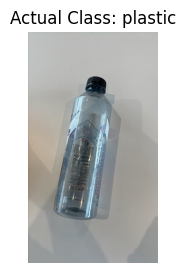

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\bottle - plastic.jpeg
True class: plastic
ResNet Predicted class: 7 - plastic
GoogleNet Predicted class: 7 - plastic
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000001,0.000037
biological,0.000001,0.000002
cardboard,0.000136,0.000022
clothes,0.000740,0.000119
glass,0.000190,0.001954
metal,0.000006,0.000221
paper,0.002348,0.000187
plastic,0.996555,0.997168
shoes,0.000003,0.000007


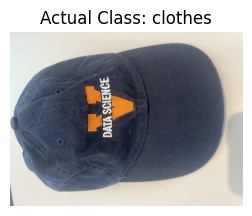

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\cap - clothes.jpg
True class: clothes
ResNet Predicted class: 3 - clothes
GoogleNet Predicted class: 3 - clothes
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000011,0.001044
biological,0.000015,0.000207
cardboard,0.000075,0.000125
clothes,0.991487,0.983744
glass,0.000001,0.000080
metal,0.001169,0.002242
paper,0.001997,0.000971
plastic,0.003560,0.001241
shoes,0.001640,0.001544


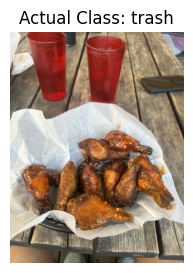

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\chicken - trash.jpg
True class: trash
ResNet Predicted class: 3 - clothes
GoogleNet Predicted class: 1 - biological
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000025,0.000194
biological,0.135606,0.640732
cardboard,0.133377,0.005531
clothes,0.348275,0.002747
glass,0.037559,0.126366
metal,0.013821,0.203371
paper,0.289870,0.007255
plastic,0.009021,0.004866
shoes,0.028337,0.000159


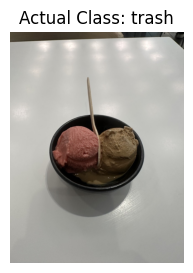

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\icecream - trash.jpg
True class: trash
ResNet Predicted class: 4 - glass
GoogleNet Predicted class: 4 - glass
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000020,0.000019
biological,0.000032,0.000359
cardboard,0.000021,0.000652
clothes,0.000047,0.000001
glass,0.775241,0.987186
metal,0.220632,0.011328
paper,0.000040,0.000012
plastic,0.002051,0.000291
shoes,0.001913,0.000136


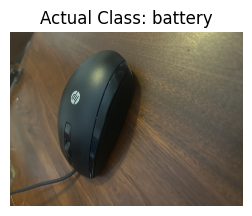

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\mouse - battery.jpg
True class: battery
ResNet Predicted class: 8 - shoes
GoogleNet Predicted class: 5 - metal
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000425,0.002506
biological,0.001021,0.002097
cardboard,0.030820,0.007226
clothes,0.162606,0.429982
glass,0.025230,0.005769
metal,0.005490,0.498389
paper,0.005186,0.004502
plastic,0.226277,0.039434
shoes,0.537179,0.006243


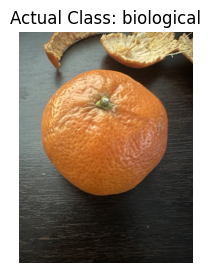

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\orange - biological.jpg
True class: biological
ResNet Predicted class: 1 - biological
GoogleNet Predicted class: 1 - biological
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000003,0.000017
biological,0.836833,0.998847
cardboard,0.000142,0.000192
clothes,0.158802,0.000694
glass,0.000126,0.000078
metal,0.001104,0.000032
paper,0.000549,0.000042
plastic,0.000125,0.000024
shoes,0.002292,0.000041


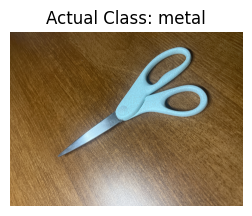

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\scissors - metal.jpg
True class: metal
ResNet Predicted class: 2 - cardboard
GoogleNet Predicted class: 9 - trash
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000152,0.000249
biological,0.000830,0.000075
cardboard,0.763447,0.027125
clothes,0.044097,0.005351
glass,0.000534,0.000204
metal,0.000138,0.003385
paper,0.067573,0.019113
plastic,0.002448,0.000345
shoes,0.114021,0.033990


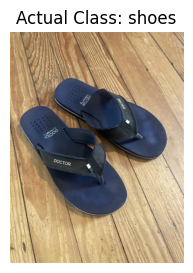

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\slippers - shoes.jpeg
True class: shoes
ResNet Predicted class: 8 - shoes
GoogleNet Predicted class: 8 - shoes
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000001,0.000412
biological,0.000028,0.000105
cardboard,0.000027,0.000035
clothes,0.012590,0.005444
glass,0.000007,0.001142
metal,0.000016,0.000077
paper,0.000152,0.000086
plastic,0.000029,0.000189
shoes,0.987141,0.992031


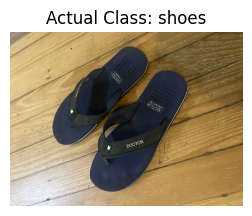

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\slippers2 - shoes.jpg
True class: shoes
ResNet Predicted class: 8 - shoes
GoogleNet Predicted class: 8 - shoes
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000002,0.000764
biological,0.000018,0.000197
cardboard,0.000017,0.000155
clothes,0.010896,0.011869
glass,0.000006,0.006846
metal,0.000008,0.000120
paper,0.000043,0.000340
plastic,0.000072,0.000230
shoes,0.988921,0.978119


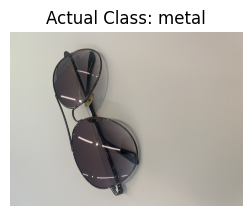

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\sunglasses - metal.jpg
True class: metal
ResNet Predicted class: 5 - metal
GoogleNet Predicted class: 4 - glass
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000342,0.000173
biological,0.002749,0.000086
cardboard,0.009103,0.001240
clothes,0.000974,0.000738
glass,0.105084,0.560143
metal,0.430105,0.311751
paper,0.375190,0.002894
plastic,0.033984,0.001092
shoes,0.025121,0.117776


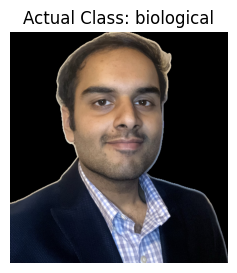

Image: D:\MSDS\Spring Term\DS6050 - DL\WISE\Test Images\\vish - biological.jpg
True class: biological
ResNet Predicted class: 6 - paper
GoogleNet Predicted class: 6 - paper
Class probabilities: 


,ResNet,GoogleNet
class,,
battery,0.000000,0.000001
biological,0.000000,0.000002
cardboard,0.000000,0.000079
clothes,0.000021,0.000077
glass,0.000000,0.000006
metal,0.000000,0.000007
paper,0.999978,0.999611
plastic,0.000000,0.000005
shoes,0.000000,0.000031


In [32]:
# image_path = os.path.join(class_path, image_file)
for image_path in test_files:
    # image_path = files[-1]  
    image_path = test_loc + image_path    
    class_name = image_path.split("\\")[-1].split(".jp")[0].split("-")[-1].strip()
    # Display the image
    img = Image.open(image_path)
    plt.figure(figsize=(3, 3))
    plt.imshow(img)
    plt.title(f"Actual Class: {class_name}")
    plt.axis('off')
    plt.show()

    # Make prediction
    rprediction, rprobabilities = predict_image(rmodel, image_path, device)
    rdf = pd.DataFrame(zip(class_dirs,rprobabilities), columns = ['class','ResNet'])
    gprediction, gprobabilities = predict_image(gmodel, image_path, device)
    gdf = pd.DataFrame(zip(class_dirs,gprobabilities), columns = ['class','GoogleNet'])

    df = rdf.merge(gdf, on='class')

    print(f"Image: {image_path}")
    print(f"True class: {class_name}")
    print(f"ResNet Predicted class: {rprediction} - {class_dirs[rprediction]}")

    print(f"GoogleNet Predicted class: {gprediction} - {class_dirs[gprediction]}")
    print(f"Class probabilities: ")
    styled_df = df.set_index('class').style.apply(lambda x: 
        [f'background-color: rgba(0, 128, 0, {v / x.max()})' for v in x], axis=0)

    display(styled_df)